# Tiempos de Colapinto - Scatterplot - BAKU 2024

Tiempos de colapa con colores de los compuestos usados en cada vuelta.


In [49]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

import fastf1.plotting
from pathlib import Path
import numpy as np

# Enable Matplotlib patches for plotting timedelta values and load
# FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme='fastf1')


Habilito cache

In [15]:
# Crear la carpeta de cache en la raíz del proyecto (proyecto/`cache`)
cache_dir = Path(r"C:\Users\aguse\OneDrive\Escritorio\PRY_AG\F1-analitics\Cache")
cache_dir.mkdir(parents=True, exist_ok=True)
print(str(cache_dir))
fastf1.Cache.enable_cache(str(cache_dir))

C:\Users\aguse\OneDrive\Escritorio\PRY_AG\F1-analitics\Cache


Load the race session.



In [16]:
race = fastf1.get_session(2024, "Azerbaijan", 'R')
race.load()

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']


Saco las vueltas de colapinto, para que sea mas estetico no tomo las muy lentas pq deforman el grafico



In [26]:
driver_laps = race.laps.pick_drivers("COL").pick_quicklaps().reset_index()

driver_laps.columns

Index(['index', 'Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber',
       'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
       'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team',
       'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted',
       'DeletedReason', 'FastF1Generated', 'IsAccurate'],
      dtype='object')

Make the scattterplot using lap number as x-axis and lap time as y-axis.
Marker colors correspond to the compounds used.
Note: as LapTime is represented by timedelta, calling setup_mpl earlier
is required.



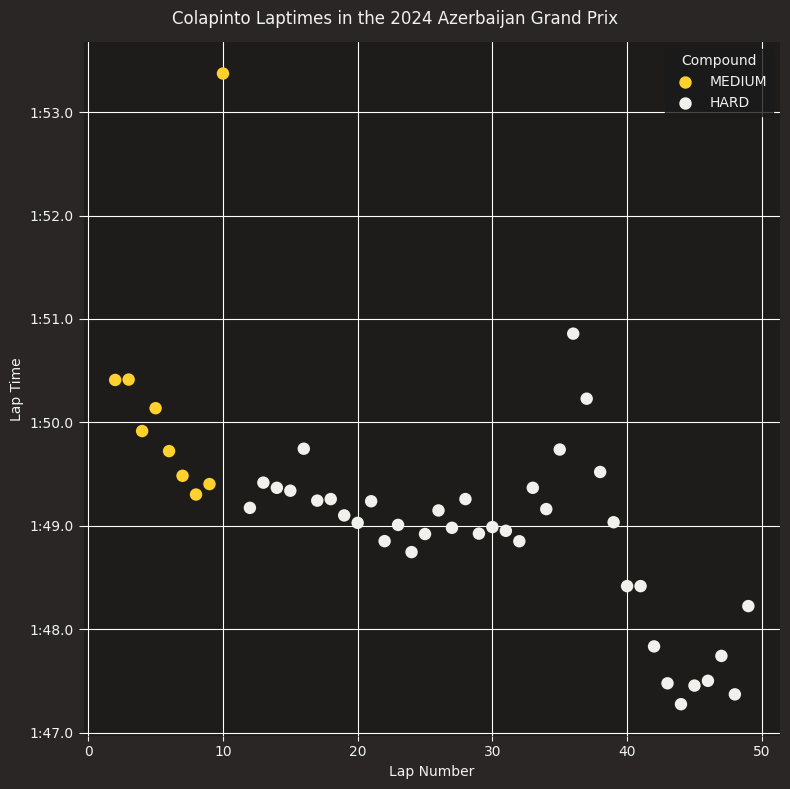

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=driver_laps,
                x="LapNumber",
                y="LapTime",
                ax=ax,
                hue="Compound",
                palette=fastf1.plotting.get_compound_mapping(session=race),
                s=80,
                linewidth=0,
                legend='auto')

ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

# The y-axis increases from bottom to top by default
# Since we are plotting time, it makes sense to invert the axis
ax.invert_yaxis()
plt.suptitle("Colapinto Laptimes in the 2024 Azerbaijan Grand Prix")

# Turn on major grid lines
plt.grid(color='w', which='major', axis='both')
sns.despine(left=True, bottom=True)

#ploteo los valores de las vueltas de colapinto

plt.tight_layout()
plt.show()

Le agrego el mapa de color con las vueltas mas rapidas y velocidades de pista



In [39]:
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors 
colormap = mpl.cm.plasma

In [40]:
lap = race.laps.pick_drivers("COL").pick_fastest() #este tiene las marcas de tiempos con una frecuencia de 5hz diria.
lap.head(10)
# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on 

Ahora ploteo el mapa de calor de velocidad en la vuelta rapida de colapinto, pero primero para hacerlo mas visual, hago segmentos de algunos puntos para ir coloreando con un gradiente de colores la velocidad en cada segmento.
La lista de segmentos son de dimension (n_lineas, puntos por linea, 2 (telemetria x e y))


In [41]:
puntos = np.array([x,y]).T.reshape(-1,1,2)
segmentos = np.concatenate([puntos[:-1], puntos[1:]], axis=1)

In [46]:
# Obtener nombre del GP de forma segura (Series o dict)
gp = race.event
gp_name = gp.get('EventName') if hasattr(gp, 'get') else gp['EventName']
print(gp_name)
# Obtener año como entero si race.date es datetime-like
race_date = getattr(race, 'date', None)
year = race_date.year if hasattr(race_date, 'year') else str(race_date)
print(f"datestamp {race_date}, year {year}")

# Obtener piloto como cadena
driver = lap.get('Driver') if hasattr(lap, 'get') else lap['Driver']
driver = str(driver)
print(driver)

Azerbaijan Grand Prix
datestamp 2024-09-15 11:00:00, year 2024
COL


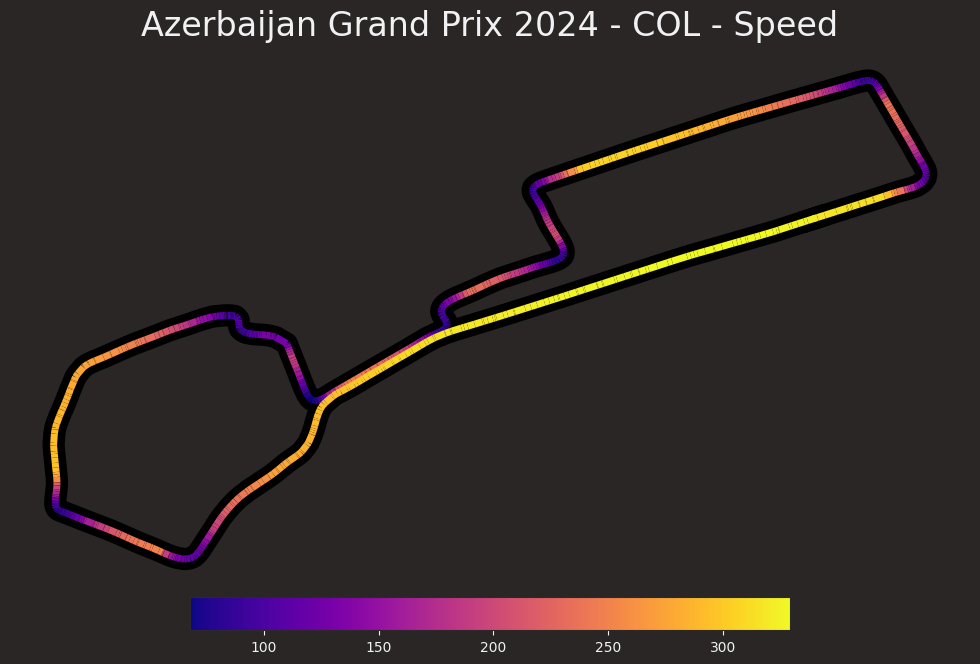

In [50]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{gp_name} {year} - {driver} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')


# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segmentos, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)


# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")


# Show the plot
plt.show()

Debajo del mapa de color, quiero ver las velocidades en una figura de tiempo-velocidad.

Text(0, 0.5, 'Speed (km/h)')

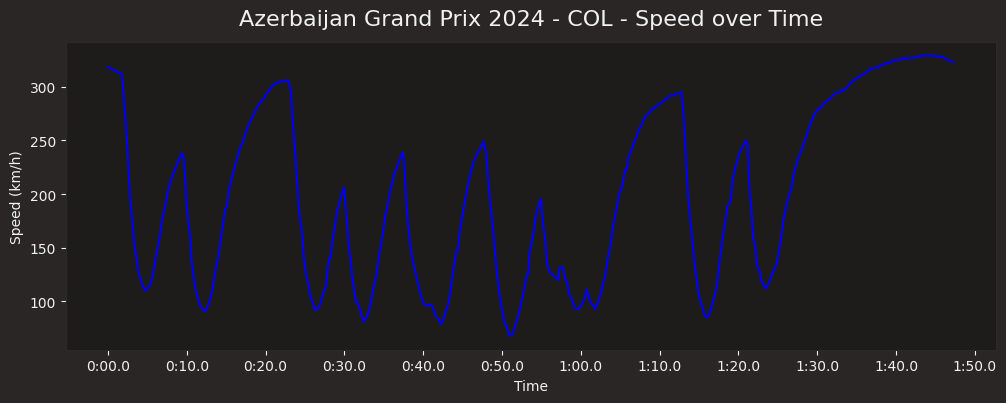

In [51]:
plt.figure(figsize=(12, 4))
plt.plot(lap.telemetry['Time'], lap.telemetry['Speed'], color='blue')
plt.title(f'{gp_name} {year} - {driver} - Speed over Time', size=16)
plt.xlabel('Time')
plt.ylabel('Speed (km/h)')      